In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import random
#For visualizations
import seaborn as sns
import matplotlib.pyplot as plt
#For data loading
import os
from PIL import Image

In [2]:
random_seed = 25

In [3]:
#For data manipulation
import skimage.morphology as skm
from skimage.color import rgb2grey

In [4]:
#For blob detection
from skimage.feature import blob_log, blob_dog, blob_doh

In [5]:
#Set up file paths and arrays
infected_address='cell_images/Parasitized'
uninfected_address ='cell_images/Uninfected'

In [6]:
#Function to import images
def import_images(address):
    dir_address = os.listdir(address)
    dir_address.remove('Thumbs.db')
    data_array = np.zeros((len(dir_address),125,125,3),dtype=np.int16)

    for ind,image_address in tqdm_notebook(enumerate(dir_address),total=len(dir_address)):
        img=Image.open(address+'/'+image_address)
        img=img.resize((125,125))
        img=np.asarray(img)
        img=img.astype(np.int16)
        data_array[ind]=img


    return data_array

In [7]:
infected_data = import_images(infected_address)



Data Import Complete!


In [8]:
uninfected_data = import_images(uninfected_address)


Data Import Complete!


In [13]:
#Visualize Data
def visualize_data(data,random_seed):
    np.random.seed(random_seed)
    random_20=np.random.randint(0,data.shape[0],size=20)
    fig=plt.figure(figsize=(10,10))
    plt.title("Data Samples")
    plt.axis('off')
    for ind,rand in enumerate(random_20):
        ax_n=fig.add_subplot(4,5,ind+1)
        ax_n.imshow(data[rand])
        ax_n.get_xaxis().set_visible(False)
        ax_n.get_yaxis().set_visible(False)
    plt.show()

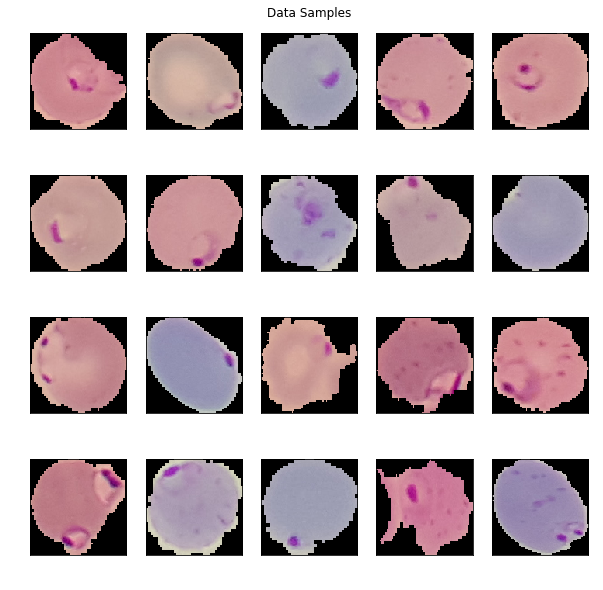

In [70]:
visualize_data(infected_data,25)

In [9]:
infected_train_labels=np.array([1]*infected_data.shape[0])

X_train_infected, X_test_infected, y_train_infected, y_test_infected = train_test_split(infected_data, infected_train_labels, test_size=0.25, random_state=25)

In [10]:
uninfected_train_labels=np.array([0]*uninfected_data.shape[0])
X_train_uninfected, X_test_uninfected, y_train_uninfected, y_test_uninfected = train_test_split(uninfected_data, uninfected_train_labels, test_size=0.25, random_state=25)

In [11]:
train=np.append(X_train_infected,X_train_uninfected,axis=0)
test=np.append(X_test_infected,X_test_uninfected,axis=0)
train_labels=np.append(y_train_infected,y_train_uninfected,axis=0)
test_labels=np.append(y_test_infected,y_test_uninfected,axis=0)

In [12]:
#shuffle train and test data for infected and uninfected
train_index=np.arange(train.shape[0])
np.random.seed(random_seed)
np.random.shuffle(train_index)
train=train[train_index]
train_labels=train_labels[train_index]

test_index=np.arange(test.shape[0])
np.random.seed(random_seed)
np.random.shuffle(test_index)
test=test[test_index]
test_labels=test_labels[test_index]

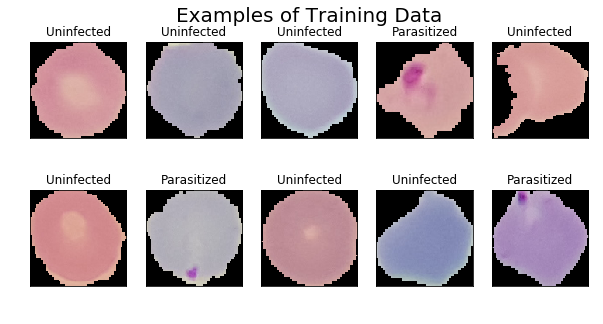

In [13]:
np.random.seed(1936)
random_10=np.random.randint(0,train.shape[0],size=10)
fig=plt.figure(figsize=(10,5))
plt.title("Examples of Training Data",fontsize=20)
plt.axis('off')
for ind,rand in enumerate(random_10):
    ax_n=fig.add_subplot(2,5,ind+1)
    ax_n.imshow(train[rand])
    if(train_labels[rand]==1):
        ax_n.set_title("Infected")
    else:
        ax_n.set_title("Uninfected")
    ax_n.get_xaxis().set_visible(False)
    ax_n.get_yaxis().set_visible(False)
plt.show()

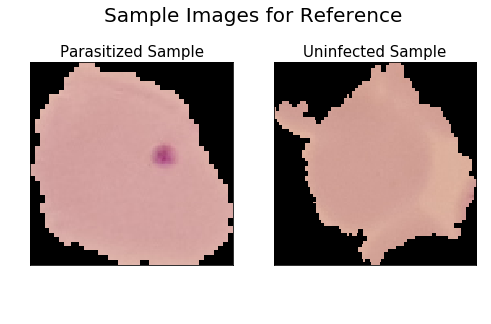

In [25]:
#Pick Random Sample to do analysis on
np.random.seed(25)
rand=np.random.randint(X_train_infected.shape[0])
infected_sample=X_train_infected[rand]
np.random.seed(25)
rand=np.random.randint(X_train_uninfected.shape[0])
uninfected_sample=X_train_uninfected[rand]

fig=plt.figure(figsize=(8,5))
plt.title("Sample Images for Reference",fontsize=20)
plt.axis('off')
ax1=fig.add_subplot(121)
ax1.imshow(infected_sample)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title("Infected Sample",fontsize=15)
ax2=fig.add_subplot(122)
ax2.imshow(uninfected_sample)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title("Uninfected Sample",fontsize=15)
plt.show()

In [275]:
#apply black tophat and plot results
def image_prep(image,to_return):
    #apply black_tophat twice to seperate out darker spots then grey
    black_tophat =skm.black_tophat(image)
    black_tophat =skm.black_tophat(black_tophat)
    #black_tophat =skm.black_tophat(black_tophat)
    grey =rgb2grey(black_tophat)

    if to_return==True:
        return grey


    fig=plt.figure(figsize=(14,5))
    plt.axis('off')
    ax1=fig.add_subplot(131)
    ax1.imshow(infected_sample)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Infected Sample",fontsize=15)
    ax1=fig.add_subplot(132)
    ax1.imshow(black_tophat)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Black Tophat Twice Sample",fontsize=15)
    ax1=fig.add_subplot(133)
    ax1.imshow(grey)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title("Skimage + Black Tophat Sample",fontsize=15)


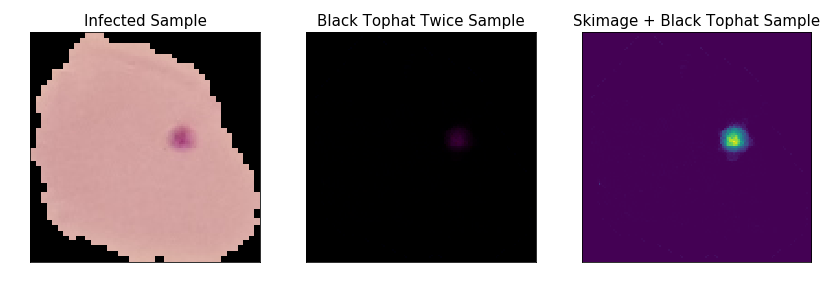

In [276]:
image_prep(infected_sample,False)

In [266]:
def detect_blobs(sample, threshold, min_sigma, max_sigma,to_return):
    #Returns manipulated version of any image (black tophat + grey)
    grey = image_prep(sample,to_return=True)
    #Blob detection returns coordinates, but only interested in count.
    #Blob_dog was final optimal approach we decided on
    log=blob_dog(grey,threshold=threshold,min_sigma=min_sigma,max_sigma=max_sigma)
    
    #Returns 1 if there are blobs (infected classification) or 0 if none found
    if(to_return==True):
        if(len(log)==0):
            return 0
        return 1


In [267]:
#Actual model, takes in image array and saves binary predictions in array
def has_blobs(data):
    predictions = np.zeros(data.shape[0])
    for ind,sample in tqdm_notebook(enumerate(data),total=data.shape[0]):
        #Optimal thresholds found for blob_dog
        predictions[ind]=detect_blobs(sample,threshold=2.5*1e-4,min_sigma=2,max_sigma=8,to_return=True)
        #predictions[ind]=detect_blobs(sample,threshold=2.5*1e-9,min_sigma=2,max_sigma=25,to_return=True)
    return predictions

In [268]:
predict = has_blobs(test)

In [269]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy = {acc:.4f}%".format(acc=accuracy_score(test_labels,predict)*100))
print("\nConfusion Matrix :")
conf_mtx = confusion_matrix(test_labels,predict, labels=[1, 0])
conf_mtx_df = pd.DataFrame(conf_mtx.T, columns=['(True) p', '(True) n'], index=['[Predicted] Y', '[Predicted] N'])
conf_mtx_df

Accuracy = 92.8302%

Confusion Matrix :


,(True) p,(True) n
[Predicted] Y,3278,327
[Predicted] N,167,3118


In [257]:
#This was used by us to look at our FN and FP samples and explore them
FN_sample = []
for ind,sample in tqdm_notebook(enumerate(test),total=test.shape[0]):
    
    if predict[ind]==0 and test_labels[ind]!=predict[ind]:
   
        FN_sample.append(ind)